In [1]:
from google.colab import drive;
drive.mount('/content/drive')

Mounted at /content/drive


# 1st run this to load the data after training

In [2]:
# English to Bodo Neural Machine Translation using real dataset files
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter
import os
import random
from tqdm.notebook import tqdm


# 2ND

In [3]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


#step 1 starts

In [4]:
# Step 1: Data Preparation - Load data from files
def load_data_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read().splitlines()
    return data

In [5]:
# Define the data paths

data_dir = "/content/drive/MyDrive/8thsem_nmt/data"
train_eng_path = os.path.join(data_dir, "dev.eng")
train_brx_path = os.path.join(data_dir, "dev.brx")
val_eng_path = os.path.join(data_dir, "val.eng")
val_brx_path = os.path.join(data_dir, "val.brx")
test_eng_path = os.path.join(data_dir, "tst.eng")
test_brx_path = os.path.join(data_dir, "tst.brx")

# Load the data
train_eng = load_data_from_file(train_eng_path)
train_brx = load_data_from_file(train_brx_path)
val_eng = load_data_from_file(val_eng_path)
val_brx = load_data_from_file(val_brx_path)
test_eng = load_data_from_file(test_eng_path)
test_brx = load_data_from_file(test_brx_path)

#BE careful here

In [ ]:
# Take only 10000 samples from training
#train_eng = train_eng[:10000]
#train_brx = train_brx[:10000]

In [6]:
# Check data loading
print(f"Training samples: {len(train_eng)}")
print(f"Validation samples: {len(val_eng)}")
print(f"Test samples: {len(test_eng)}")

Training samples: 32149
Validation samples: 665
Test samples: 444


In [7]:
# Check if data sizes match
assert len(train_eng) == len(train_brx), "Training data size mismatch"
assert len(val_eng) == len(val_brx), "Validation data size mismatch"
assert len(test_eng) == len(test_brx), "Test data size mismatch"

# Display some examples
print("\nSample data:")
for i in range(min(3, len(train_eng))):
    print(f"English: {train_eng[i]}")
    print(f"Bodo: {train_brx[i]}")
    print()



Sample data:
English: Additionally many drug companies will work with your doctor or health care provider to supply free medicines to those in need .
Bodo: लोगोसे , गोबां मुलि दोलोया जाय बेसेनगैयै मुलि नांनायफोरनो होनो नोंनि देहाफामगिरि एबा देहास्रि जोथोन जगायग्राजों मावगोन ।

English: Adolescence represents a window of opportunity to prepare for a healthy adult life .
Bodo: जौमोन बैसोया दिन्थियो मोनसे सुजुगनि खिरखि मोनसे देहागोनां बैसोगोरा जिवनि थाखाय थियारि खालामनो ।

English: Appropriate feeding practices stimulate bonding with the caregiver and psycho social development .
Bodo: आहार जाहोनो थिगयै सोलोंनाया जोथोनहोगिरि आरो सायख - ससिएल जौगानाय जों नांथाबनायखौ थुलुंगाहोयो ।



#step 2 starts

In [8]:
# Step 2: Text Processing
class LanguageProcessor:
    def __init__(self, sentences, max_vocab_size=50000):
        self.sentences = sentences
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.word_count = Counter()
        self.max_length = 0
        self.max_vocab_size = max_vocab_size
        self.process_sentences()

    def process_sentences(self):
        for sentence in self.sentences:
            self.max_length = max(self.max_length, len(sentence.split()) + 2)  # +2 for SOS and EOS
            for word in sentence.split():
                self.word_count[word] += 1

        # Keep only the most frequent words
        most_common = self.word_count.most_common(self.max_vocab_size - 4)  # -4 for special tokens
        for word, count in most_common:
            if word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word

        print(f"Vocabulary size: {len(self.word2idx)}")
        print(f"Max sentence length: {self.max_length}")

    def tokenize(self, sentence):
        tokens = ['<SOS>']
        tokens.extend([word if word in self.word2idx else '<UNK>' for word in sentence.split()])
        tokens.append('<EOS>')
        return tokens

    def convert_to_indices(self, sentence):
        tokens = self.tokenize(sentence)
        indices = [self.word2idx[token] for token in tokens]
        return indices

    def convert_to_words(self, indices):
        return [self.idx2word[idx] if idx in self.idx2word else '<UNK>' for idx in indices]

    def pad_sequence(self, indices):
        padded = indices + [self.word2idx['<PAD>']] * (self.max_length - len(indices))
        return padded[:self.max_length]


In [9]:

# Process English and Bodo sentences
english_processor = LanguageProcessor(train_eng)
bodo_processor = LanguageProcessor(train_brx)

Vocabulary size: 40601
Max sentence length: 179
Vocabulary size: 50000
Max sentence length: 147


#step 3

In [10]:
# Step 3: Create Dataset and DataLoader
class TranslationDataset(Dataset):
    def __init__(self, english_sentences, bodo_sentences, english_processor, bodo_processor):
        self.english_sentences = english_sentences
        self.bodo_sentences = bodo_sentences
        self.english_processor = english_processor
        self.bodo_processor = bodo_processor

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        english_sentence = self.english_sentences[idx]
        bodo_sentence = self.bodo_sentences[idx]

        english_indices = self.english_processor.convert_to_indices(english_sentence)
        bodo_indices = self.bodo_processor.convert_to_indices(bodo_sentence)

        english_padded = self.english_processor.pad_sequence(english_indices)
        bodo_padded = self.bodo_processor.pad_sequence(bodo_indices)

        return {
            'src': torch.tensor(english_padded, dtype=torch.long),
            'tgt': torch.tensor(bodo_padded, dtype=torch.long),
            'src_len': len(english_indices),
            'tgt_len': len(bodo_indices)
        }


In [11]:

# Create datasets
train_dataset = TranslationDataset(train_eng, train_brx, english_processor, bodo_processor)
val_dataset = TranslationDataset(val_eng, val_brx, english_processor, bodo_processor)
test_dataset = TranslationDataset(test_eng, test_brx, english_processor, bodo_processor)


#change the batch size according to your system
#Batch size

In [12]:
# Create dataloaders
BATCH_SIZE = 64  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


#step 4TH

In [13]:
# Step 4: Encoder-Decoder Architecture with Attention
# Fix for the hidden state dimension mismatch error
# Modify the Encoder class to properly handle hidden state dimensions

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, src_len, emb_dim]

        outputs, hidden = self.rnn(embedded)
        # outputs: [batch_size, src_len, hidden_dim * 2]
        # hidden: [n_layers * 2, batch_size, hidden_dim]

        # Convert bidirectional hidden states to the right shape for the decoder
        # First, separate forward and backward hidden states
        forward_hidden = hidden[:self.n_layers]  # [n_layers, batch_size, hidden_dim]
        backward_hidden = hidden[self.n_layers:]  # [n_layers, batch_size, hidden_dim]

        # Combine forward and backward hidden states
        combined_hidden = []
        for i in range(self.n_layers):
            combined = torch.cat((forward_hidden[i], backward_hidden[i]), dim=1)  # [batch_size, hidden_dim*2]
            combined = self.fc(combined).unsqueeze(0)  # [1, batch_size, hidden_dim]
            combined_hidden.append(combined)

        # Stack the layers
        hidden = torch.cat(combined_hidden, dim=0)  # [n_layers, batch_size, hidden_dim]

        return outputs, hidden


functions define

In [14]:
# Also update the Decoder class to properly handle hidden state dimensions
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hidden_dim * 2) + emb_dim, dec_hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.n_layers = n_layers

    def forward(self, input, hidden, encoder_outputs, mask=None):
        # input: [batch_size]
        # hidden: [n_layers, batch_size, dec_hidden_dim]
        # encoder_outputs: [batch_size, src_len, enc_hidden_dim * 2]

        input = input.unsqueeze(1)  # Add sequence dimension
        # input: [batch_size, 1]

        embedded = self.dropout(self.embedding(input))
        # embedded: [batch_size, 1, emb_dim]

        # Use only the last layer for attention calculation
        last_hidden = hidden[-1].unsqueeze(0)  # [1, batch_size, dec_hidden_dim]

        # Calculate attention
        attention_weights = self.attention(last_hidden, encoder_outputs, mask)
        # attention_weights: [batch_size, src_len]

        attention_weights = attention_weights.unsqueeze(1)
        # attention_weights: [batch_size, 1, src_len]

        # Apply attention to encoder outputs
        context = torch.bmm(attention_weights, encoder_outputs)
        # context: [batch_size, 1, enc_hidden_dim * 2]

        # Concatenate embedded and context
        rnn_input = torch.cat((embedded, context), dim=2)
        # rnn_input: [batch_size, 1, emb_dim + enc_hidden_dim * 2]

        output, hidden = self.rnn(rnn_input, hidden)
        # output: [batch_size, 1, dec_hidden_dim]
        # hidden: [n_layers, batch_size, dec_hidden_dim]

        # Remove sequence dimension
        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        context = context.squeeze(1)

        # Concatenate for prediction
        prediction_input = torch.cat((output, context, embedded), dim=1)
        # prediction_input: [batch_size, dec_hidden_dim + enc_hidden_dim * 2 + emb_dim]

        prediction = self.fc_out(prediction_input)
        # prediction: [batch_size, output_dim]

        return prediction, hidden



attention functions

In [15]:
# Also update the Attention class to handle the updated hidden state shape
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [1, batch_size, dec_hidden_dim]
        # encoder_outputs: [batch_size, src_len, enc_hidden_dim * 2]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # Repeat hidden to match encoder_outputs dimensions
        hidden = hidden.permute(1, 0, 2).repeat(1, src_len, 1)
        # hidden: [batch_size, src_len, dec_hidden_dim]

        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy: [batch_size, src_len, dec_hidden_dim]

        attention = self.v(energy).squeeze(2)
        # attention: [batch_size, src_len]

        # Apply mask if provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        return torch.softmax(attention, dim=1)


sequestion function

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src):
        # Create mask for padding
        mask = (src != 0).float()
        return mask

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_dim

        # Create mask for attention
        mask = self.create_mask(src)

        # Initialize outputs tensor
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Get encoder outputs and hidden state
        encoder_outputs, hidden = self.encoder(src)

        # First input to the decoder is the <SOS> token
        input = tgt[:, 0]

        for t in range(1, tgt_len):
            # Get decoder output
            output, hidden = self.decoder(input, hidden, encoder_outputs, mask)

            # Store output
            outputs[:, t] = output

            # Teacher forcing: decide whether to use real target or prediction
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1)

            # Use either target or predicted token as next input
            input = tgt[:, t] if teacher_force else top1

        return outputs

#step 5th

In [17]:
# Step 5: Initialize Model
INPUT_DIM = len(english_processor.word2idx)
OUTPUT_DIM = len(bodo_processor.word2idx)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Create attention layer
attention = Attention(ENC_HID_DIM, DEC_HID_DIM)

# Initialize encoder and decoder
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attention)

# Create Seq2Seq model
model = Seq2Seq(encoder, decoder, device).to(device)

# Initialize weights
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

# Print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')



The model has 125,577,808 trainable parameters


#step 6

In [18]:
# Step 6: Define Loss Function and Optimizer
PAD_IDX = bodo_processor.word2idx['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#step 7

In [19]:
# Step 7: Training Loop
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for batch in tqdm(iterator, desc="Training"):
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        optimizer.zero_grad()

        output = model(src, tgt)

        # Remove first token (<SOS>)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model(src, tgt, 0)  # No teacher forcing during evaluation

            # Remove first token (<SOS>)
            output = output[:, 1:].reshape(-1, output.shape[2])
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

#step 8

#change the Epoch!!!!!!!

In [20]:
# Step 8: Training the Model
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')
patience_counter = 0
PATIENCE = 10  # Early stopping



#change the model directory

In [21]:
# Create a directory inside MyDrive
save_dir = '/content/drive/MyDrive/8thsem_nmt/model1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Create a directory to save models
#if not os.path.exists('models'):
#    os.makedirs('models')

#give the path according  to your model     torch.save(model.state_dict(), '/content/drive/MyDrive/models/english-bodo-nmt.pt')

In [22]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    # Update learning rate based on validation loss
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt.pt')
        print(f'\tSaved best model with loss: {valid_loss:.4f}')
    else:
        patience_counter += 1

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.4f}')
    print(f'\tValidation Loss: {valid_loss:.4f}')

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f'Early stopping after {epoch+1} epochs')
        break

Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

	Saved best model with loss: 6.5895
Epoch: 01
	Train Loss: 7.5558
	Validation Loss: 6.5895


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

	Saved best model with loss: 6.2946
Epoch: 02
	Train Loss: 6.7554
	Validation Loss: 6.2946


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

	Saved best model with loss: 6.0322
Epoch: 03
	Train Loss: 6.1023
	Validation Loss: 6.0322


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

	Saved best model with loss: 5.9979
Epoch: 04
	Train Loss: 5.3212
	Validation Loss: 5.9979


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 4.5485
	Validation Loss: 6.0811


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 4.0631
	Validation Loss: 6.1044


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 3.8279
	Validation Loss: 6.1112


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 3.5944
	Validation Loss: 6.1337


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 3.3864
	Validation Loss: 6.2146


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 3.2105
	Validation Loss: 6.2632


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 2.8787
	Validation Loss: 6.2073


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 2.5386
	Validation Loss: 6.3167


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 2.3860
	Validation Loss: 6.3734


Training:   0%|          | 0/503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 2.2761
	Validation Loss: 6.4734
Early stopping after 14 epochs


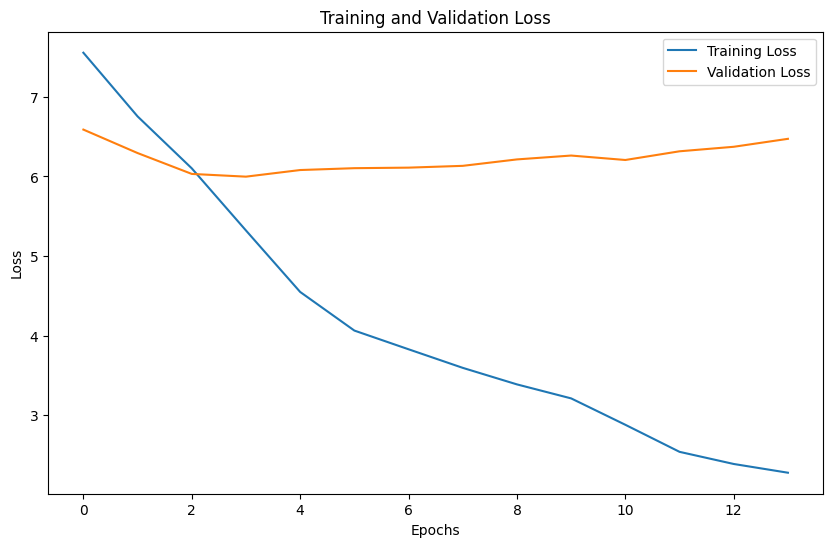

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/8thsem_nmt/model1/loss_plot.png')
plt.show()

#step 9

In [24]:
# Step 9: Calculate BLEU Score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu(model, test_loader, bodo_processor):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Calculating BLEU"):
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            batch_size = src.shape[0]

            # Encode source sentences
            encoder_outputs, hidden = model.encoder(src)

            # Create list for storing hypotheses
            batch_hypotheses = [[] for _ in range(batch_size)]

            # Create list for references
            batch_references = []

            # Convert target sentences to words
            for i in range(batch_size):
                # Get target sentence (excluding <SOS> and <PAD>)
                tgt_sentence = tgt[i].cpu().numpy()
                # Remove padding
                tgt_sentence = tgt_sentence[tgt_sentence != PAD_IDX]
                # Remove <SOS>
                tgt_sentence = tgt_sentence[1:]
                # Remove <EOS> if present
                if 2 in tgt_sentence:  # 2 is <EOS>
                    tgt_sentence = tgt_sentence[:np.where(tgt_sentence == 2)[0][0]]

                # Convert to words
                tgt_words = bodo_processor.convert_to_words(tgt_sentence)
                batch_references.append([tgt_words])

            # Start with <SOS> token
            input = torch.tensor([bodo_processor.word2idx['<SOS>']] * batch_size).to(device)

            # Create mask for attention
            mask = model.create_mask(src)

            for _ in range(100):  # Maximum generation length
                # Get decoder output
                output, hidden = model.decoder(input, hidden, encoder_outputs, mask)

                # Get predicted token
                pred_tokens = output.argmax(1)

                # Store predictions
                for i, token in enumerate(pred_tokens):
                    if token.item() != bodo_processor.word2idx['<EOS>'] and len(batch_hypotheses[i]) < 100:
                        batch_hypotheses[i].append(token.item())

                # Use predicted tokens as next input
                input = pred_tokens

                # Stop if all sequences have generated <EOS>
                if all((token == bodo_processor.word2idx['<EOS>'] or len(batch_hypotheses[i]) >= 100) for i, token in enumerate(pred_tokens)):
                    break

            # Convert hypotheses to words
            batch_hypotheses = [bodo_processor.convert_to_words(hyp) for hyp in batch_hypotheses]

            # Add to corpus references and hypotheses
            references.extend(batch_references)
            hypotheses.extend(batch_hypotheses)

    # Calculate BLEU score
    smoothing = SmoothingFunction().method1
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    return bleu1, bleu2, bleu3, bleu4

In [25]:
# Load best model and calculate BLEU score
#model.load_state_dict(torch.load('/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt.pt', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt.pt'))
bleu1, bleu2, bleu3, bleu4 = calculate_bleu(model, test_loader, bodo_processor)

print(f'BLEU-1: {bleu1*100:.2f}')
print(f'BLEU-2: {bleu2*100:.2f}')
print(f'BLEU-3: {bleu3*100:.2f}')
print(f'BLEU-4: {bleu4*100:.2f}')

Calculating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

BLEU-1: 14.64
BLEU-2: 6.23
BLEU-3: 2.89
BLEU-4: 1.33


In [26]:
# Step 10: Translation Function
def translate_sentence(sentence, src_processor, tgt_processor, model, device, max_len=100):
    model.eval()

    # Process input sentence
    indices = src_processor.convert_to_indices(sentence)
    tensor = torch.LongTensor(indices).unsqueeze(0).to(device)

    # Create mask for attention
    mask = model.create_mask(tensor)

    # Get encoder outputs
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(tensor)

    # Start with <SOS> token
    tgt_indices = [tgt_processor.word2idx['<SOS>']]

    for i in range(max_len):
        tgt_tensor = torch.LongTensor([tgt_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden = model.decoder(tgt_tensor, hidden, encoder_outputs, mask)

        # Get predicted token
        pred_token = output.argmax(1).item()
        tgt_indices.append(pred_token)

        # Stop if <EOS> token is predicted
        if pred_token == tgt_processor.word2idx['<EOS>']:
            break

    # Convert indices to tokens
    tgt_tokens = tgt_processor.convert_to_words(tgt_indices)

    # Remove <SOS> and <EOS> tokens
    if '<EOS>' in tgt_tokens:
        tgt_tokens = tgt_tokens[1:tgt_tokens.index('<EOS>')]
    else:
        tgt_tokens = tgt_tokens[1:]

    return ' '.join(tgt_tokens)

#load the model according to your saved model

In [27]:
# Step 11: Test the Model on Test Set
def test_translation(num_examples=5):
    # Load best model
    model.load_state_dict(torch.load('/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt.pt'))

    # Test on test set
    test_indices = random.sample(range(len(test_eng)), min(num_examples, len(test_eng)))

    print("\nTest set examples:")
    for idx in test_indices:
        eng_sentence = test_eng[idx]
        actual_brx = test_brx[idx]
        predicted_brx = translate_sentence(eng_sentence, english_processor, bodo_processor, model, device)

        print(f"English: {eng_sentence}")
        print(f"Actual Bodo: {actual_brx}")
        print(f"Predicted Bodo: {predicted_brx}")
        print()

# Run the test
test_translation()


Test set examples:
English: Make your trip to Vaishno Devi a memorable event by staying at the right kind of accommodation .
Actual Bodo: नोंसोर थार रोखोमनि थानाय - खाबुवाव थानानै नोंनि बिष्नु देबिसिम दावबायनायखौ गोसोखांथाव जाथाय खालाम ।
Predicted Bodo: नोंनि दावबायनायखौ नोंनि दावबायनायखौ नोंनि <UNK> नोंनि <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

English: Listen to the melodies generated by the shimmering backwaters and how ubiquitous coconut leaves drum the soft breeze that g


# #*change* the model path to your model


In [28]:
# Step 12: Save Processors for Future Use
import pickle

with open('/content/drive/MyDrive/8thsem_nmt/model1/english_processor.pkl', 'wb') as f:
    pickle.dump(english_processor, f)

with open('//content/drive/MyDrive/8thsem_nmt/model1/bodo_processor.pkl', 'wb') as f:
    pickle.dump(bodo_processor, f)

print("Model and processors saved successfully!")

Model and processors saved successfully!


#while loading u can skip this

In [29]:
# Step 13: Create a simple web interface using Jupyter widgets
try:
    from ipywidgets import widgets
    from IPython.display import display, clear_output

    def translate_callback(button):
        with output:
            clear_output()
            input_text = input_widget.value
            if input_text:
                translation = translate_sentence(input_text, english_processor, bodo_processor, model, device)
                print(f"English: {input_text}")
                print(f"Bodo Translation: {translation}")

    # Create widgets
    input_widget = widgets.Textarea(
        value='',
        placeholder='Enter English text here',
        description='English:',
        layout=widgets.Layout(width='80%', height='100px')
    )

    translate_button = widgets.Button(
        description='Translate',
        button_style='primary',
        layout=widgets.Layout(width='200px')
    )

    output = widgets.Output()

    # Add callback
    translate_button.on_click(translate_callback)

    # Display widgets
    print("Interactive Translation Interface")
    display(input_widget)
    display(translate_button)
    display(output)

except ImportError:
    print("ipywidgets not available, skipping web interface creation")

    # Alternative: Command-line interactive translation
    def interactive_translation():
        # Load best model
        model.load_state_dict(torch.load('/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt.pt'))

        print("English to Bodo Neural Machine Translation")
        print("Type 'quit' to exit")

        while True:
            input_sentence = input("\nEnter English text: ")

            if input_sentence.lower() == 'quit':
                break

            translation = translate_sentence(input_sentence, english_processor, bodo_processor, model, device)
            print(f"Bodo Translation: {translation}")

    # Run interactive translation
    print("\nStarting interactive translation session...")
    interactive_translation()






Interactive Translation Interface


Textarea(value='', description='English:', layout=Layout(height='100px', width='80%'), placeholder='Enter Engl…

Button(button_style='primary', description='Translate', layout=Layout(width='200px'), style=ButtonStyle())

Output()

#!!!!Most important part of all check the nodel path carefully

In [30]:
torch.save(model, '/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt_full_model.pt')

#To load the model on cpu

In [ ]:
#model = torch.load('/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt_full_model.pt', map_location=torch.device('cpu'), weights_only=False)
#model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14835, 256)
    (rnn): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(31401, 256)
    (rnn): GRU(1280, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=1792, out_features=31401, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

#for GPU

In [32]:
model = torch.load('/content/drive/MyDrive/8thsem_nmt/model1/english-bodo-nmt_full_model.pt', weights_only=False)
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(40601, 256)
    (rnn): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(50000, 256)
    (rnn): GRU(1280, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=1792, out_features=50000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [33]:
import pickle

# Load processors
with open('/content/drive/MyDrive/8thsem_nmt/model1/english_processor.pkl', 'rb') as f:
    english_processor = pickle.load(f)

with open('/content/drive/MyDrive/8thsem_nmt/model1/bodo_processor.pkl', 'rb') as f:
    bodo_processor = pickle.load(f)

print("Model and processors loaded successfully!")

Model and processors loaded successfully!


In [36]:
sentence = "this is a common."
translation = translate_sentence(sentence, english_processor, bodo_processor, model, device)
print("Bodo Translation:", translation)

Bodo Translation: बेयो बेयो बेयो मोनसे बेयो मोनसे बेयो मोनसे बेयो मोनसे बेयो मोनसे बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो मोनसे <UNK> बेयो


In [37]:
bleu1, bleu2, bleu3, bleu4 = calculate_bleu(model, test_loader, bodo_processor)

print(f'BLEU-1: {bleu1*100:.2f}')
print(f'BLEU-2: {bleu2*100:.2f}')
print(f'BLEU-3: {bleu3*100:.2f}')
print(f'BLEU-4: {bleu4*100:.2f}')

Calculating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

BLEU-1: 14.64
BLEU-2: 6.23
BLEU-3: 2.89
BLEU-4: 1.33
